# Imports

In [33]:
import xgboost as xgb
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set()
import shap

# Utils

In [34]:
from sklearn.metrics import average_precision_score, log_loss

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def relative_cross_entropy_score(gt, pred):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

def compute_score(y_true, y_score):
    ap = average_precision_score(y_true, y_score)
    rce = relative_cross_entropy_score(y_true, y_score)
    return ap, rce

def pretty_evaluation(results):
    mAP = (
        results['retweet_AP']
        +results['reply_AP']
        +results['like_AP']
        +results['retweet_with_comment_AP']
    ) / 4
    mRCE = (
        results['retweet_RCE']
        +results['reply_RCE']
        +results['like_RCE']
        +results['retweet_with_comment_RCE']
    ) / 4
    return f"""
---------------------------------
AP Retweet:                {results['retweet_AP']:.4f}
RCE Retweet:               {results['retweet_RCE']:.4f}
---------------------------------
AP Reply:                  {results['reply_AP']:.4f}
RCE Reply:                 {results['reply_RCE']:.4f}
---------------------------------
AP Like:                   {results['like_AP']:.4f}
RCE Like:                  {results['like_RCE']:.4f}
---------------------------------
AP RT with comment:        {results['retweet_with_comment_AP']:.4f}
RCE RT with comment:       {results['retweet_with_comment_RCE']:.4f}

---------------------------------

mAP                        {mAP:.4f}
mRCE                       {mRCE:.4f}

""".strip()

def just_mAP_mRCE(results):
    mAP = (
        results['retweet_AP']
        +results['reply_AP']
        +results['like_AP']
        +results['retweet_with_comment_AP']
    ) / 4
    mRCE = (
        results['retweet_RCE']
        +results['reply_RCE']
        +results['like_RCE']
        +results['retweet_with_comment_RCE']
    ) / 4
    return f"""
mAP                        {mAP:.4f}
mRCE                       {mRCE:.4f}

""".strip()

# Loading in data

In [35]:
features = [
    "text_tokens",
    "hashtags",
    "tweet_id",
    "present_media",
    "present_links",
    "present_domains",
    "tweet_type",
    "language",
    "tweet_timestamp",
    "engaged_with_user_id",
    "engaged_with_user_follower_count",
    "engaged_with_user_following_count",
    "engaged_with_user_is_verified",
    "engaged_with_user_account_creation",
    "engaging_user_id",
    "engaging_user_follower_count",
    "engaging_user_following_count",
    "engaging_user_is_verified",
    "engaging_user_account_creation",
    "engagee_follows_engager",
]

features_idx = dict(zip(features, range(len(features))))

labels_idx = {
    "reply_timestamp": 20,
    "retweet_timestamp": 21,
    "retweet_with_comment_timestamp": 22,
    "like_timestamp": 23,
}
names = features + list(labels_idx)

In [36]:
df = pd.read_csv('../data/raw/sample_200k_rows', names=names, sep='\x01')
df = df.assign(**{
    "reply": df["reply_timestamp"].notna(),
    "retweet": df["retweet_timestamp"].notna(),
    "retweet_with_comment": df["retweet_with_comment_timestamp"].notna(),
    "like": df["like_timestamp"].notna()
})

In [37]:
df

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,...,engaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp,reply,retweet,retweet_with_comment,like
0,101\t10289\t19348\t18519\t784\t59269\t16849\t1...,NaN,D798864A80C4B28B7A75B8E411C24728,NaN,NaN,NaN,Quote,9A78FC330083E72BE0DD1EA92656F3B5,1613912916,044FED4C9797C84D59C33585CF6EC690,...,1548003258,False,NaN,NaN,NaN,1.613913e+09,False,False,False,True
1,101\t56898\t137\t171\t20246\t168\t194\t46671\t...,NaN,3F3153D1EEE6C4B3C1546BA9997AC1D7,Photo,NaN,NaN,Retweet,E7F038DE3EAD397AEC9193686C911677,1613783112,999C0EEFEDB7E7C3585CC33EB0FE65DC,...,1458890236,False,NaN,NaN,NaN,NaN,False,False,False,False
2,101\t14535\t189\t58768\t82856\t191\t10911\t113...,NaN,26DC4B642DA4DA97E469305A03D20829,NaN,NaN,NaN,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,1613290787,5F1CAD78B474A0F5888552ECD92A3DCC,...,1246210670,False,NaN,NaN,NaN,1.613321e+09,False,False,False,True
3,101\t150\t86888\t41275\t110909\t10738\t142\t39...,NaN,FB828E786FDDDEFB5827832967496B61,Photo,72D7397E286C3CD4BD41D0CF2C76A835,F595B7DE8992A3D8C7948B4E81419D78,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,1612471288,4273D91B4A3FA9464C2CFBA738D4080D,...,1292185341,False,NaN,NaN,NaN,NaN,False,False,False,False
4,101\t1919\t27843\t101955\t18226\t12230\t22396\...,NaN,ADC4085E3313C32E2F9151134FE37674,NaN,NaN,NaN,Quote,E7F038DE3EAD397AEC9193686C911677,1613998385,1A89120910A5DC201E746DFB2E43F773,...,1529061495,False,NaN,NaN,NaN,1.614003e+09,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224094,101\t56898\t137\t74004\t83779\t168\t49409\t110...,NaN,9E85CCA16A556C2599F93FFA477C1C28,Video,NaN,NaN,Retweet,B8B04128918BBF54E2E178BFF1ABA833,1613245388,70566B1733BB045EFCAEBB9B8B372CF0,...,1580507486,False,NaN,NaN,NaN,NaN,False,False,False,False
224095,101\t97593\t24512\t761\t16498\t34414\t10461\t5...,NaN,7D52A1609D717EA16C7B7C35A5C9FC72,NaN,NaN,NaN,TopLevel,9A78FC330083E72BE0DD1EA92656F3B5,1612827555,B7EDB18056E3C2388D0BD8F062ADD649,...,1564593210,False,NaN,NaN,NaN,NaN,False,False,False,False
224096,101\t31301\t183\t119\t91327\t10107\t100\t108\t...,F6EBCDE6330715CA874FCB6A075F9ABA,6DC57A2E891088D7FACE14A59DBBA19F,NaN,NaN,NaN,Quote,488B32D24BD4BB44172EB981C1BCA6FA,1612531477,5D36A0CC44532FD3DAABC3636548A712,...,1510873142,False,NaN,NaN,NaN,NaN,False,False,False,False
224097,101\t56898\t137\t13518\t11517\t11889\t50555\t1...,NaN,CA9B0D5A77F18111DF18BCCE1112E682,NaN,NaN,NaN,Retweet,9A78FC330083E72BE0DD1EA92656F3B5,1613128148,22132BE53D4E6224E7329F1D11656BFF,...,1503746706,True,NaN,NaN,NaN,NaN,False,False,False,False


# Trainining, Validation, Testing split

In [38]:
%%time
# Holdout split
df_train = df.iloc[0                 :int(len(df) * 0.6)]
df_valid = df.iloc[int(len(df) * 0.6):int(len(df) * 0.8)]
df_test = df.iloc [int(len(df) * 0.8):                  ]

CPU times: user 311 µs, sys: 31 µs, total: 342 µs
Wall time: 348 µs


# Feature Engineering

In [39]:
targets = ["reply", "retweet", "retweet_with_comment", "like"]

enabled_features = [
    # Tweet features
    "present_media",
    "tweet_type",
    "language",
    "tweet_timestamp",
    # Engaged-with User (i.e., Engagee) Features
    "engaged_with_user_id",
    "engaged_with_user_follower_count",
    "engaged_with_user_following_count",
    "engaged_with_user_is_verified",
    "engaged_with_user_account_creation",

    # Engaging User (i.e., Engager) Features
    "engaging_user_id",
    "engaging_user_follower_count",
    "engaging_user_following_count",
    "engaging_user_is_verified",
    "engaging_user_account_creation",
    # Engagement features
    "engagee_follows_engager",
    
    # Targets (will be ignored later)
    "reply_timestamp",
    "retweet_timestamp",
    "retweet_with_comment_timestamp",
    "like_timestamp",
]

categorical_features = [
    'language',
    'tweet_type',
    'present_media',
    "engaged_with_user_id",
    "engaging_user_id",
]

## Original features

In [40]:
%%time
# Features from original dataset
df_train_features = df_train[enabled_features]
df_valid_features = df_valid[enabled_features]
df_test_features = df_test[enabled_features]

CPU times: user 19 ms, sys: 0 ns, total: 19 ms
Wall time: 17.9 ms


## Tweet time features

In [41]:
%%time
def tweet_time_features(df):
    timestamp_dt = pd.to_datetime(df['tweet_timestamp'])
    return {
        'dt_dow': timestamp_dt.dt.weekday,
        'dt_hour': timestamp_dt.dt.hour,
        'dt_minute': timestamp_dt.dt.minute,
        'dt_second': timestamp_dt.dt.second,
    }

df_train_features = df_train_features.assign(**tweet_time_features(df_train_features))
df_valid_features = df_valid_features.assign(**tweet_time_features(df_train_features))
df_test_features = df_test_features.assign(**tweet_time_features(df_train_features))

CPU times: user 209 ms, sys: 7.36 ms, total: 217 ms
Wall time: 218 ms


## `engage_time`

In [42]:
def engage_time_feature(df):
    return {
        'engage_time': df[labels_idx].min(axis=1)
    }

df_train_features = df_train_features.assign(**engage_time_feature(df_train_features))
df_valid_features = df_valid_features.assign(**engage_time_feature(df_train_features))
df_test_features = df_test_features.assign(**engage_time_feature(df_train_features))

## `elapsed_time`

In [43]:
def elapsed_time_feature(df):
    return {
        'elapsed_time': df['engage_time'] - df['tweet_timestamp']
    }

df_train_features = df_train_features.assign(**elapsed_time_feature(df_train_features))
df_valid_features = df_valid_features.assign(**elapsed_time_feature(df_train_features))
df_test_features = df_test_features.assign(**elapsed_time_feature(df_train_features))

## Single target encode

In [44]:
class MTE_one_shot:
    
    def __init__(self, folds, smooth, seed=42):
        self.folds = folds
        self.seed = seed
        self.smooth = smooth
        
    def fit_transform(self, train, x_col, y_col, y_mean=None, out_col = None, out_dtype=None):
        
        self.y_col = y_col
        np.random.seed(self.seed)
        
        if 'fold' not in train.columns:
            fsize = len(train)//self.folds
            train['fold'] = 1
            train['fold'] = train['fold'].cumsum()
            train['fold'] = train['fold']//fsize
            train['fold'] = train['fold']%self.folds
        
        if out_col is None:
            tag = x_col if isinstance(x_col,str) else '_'.join(x_col)
            out_col = f'TE_{tag}_{self.y_col}'
        
        if y_mean is None:
            y_mean = train[y_col].mean()#.compute().astype('float32')
        self.mean = y_mean
        
        cols = ['fold',x_col] if isinstance(x_col,str) else ['fold']+x_col
        
        agg_each_fold = train.groupby(cols).agg({y_col:['count','sum']}).reset_index()
        agg_each_fold.columns = cols + ['count_y','sum_y']
        
        agg_all = agg_each_fold.groupby(x_col).agg({'count_y':'sum','sum_y':'sum'}).reset_index()
        cols = [x_col] if isinstance(x_col,str) else x_col
        agg_all.columns = cols + ['count_y_all','sum_y_all']
        
        agg_each_fold = agg_each_fold.merge(agg_all,on=x_col,how='left')
        agg_each_fold['count_y_all'] = agg_each_fold['count_y_all'] - agg_each_fold['count_y']
        agg_each_fold['sum_y_all'] = agg_each_fold['sum_y_all'] - agg_each_fold['sum_y']
        agg_each_fold[out_col] = (agg_each_fold['sum_y_all']+self.smooth*self.mean)/(agg_each_fold['count_y_all']+self.smooth)
        agg_each_fold = agg_each_fold.drop(['count_y_all','count_y','sum_y_all','sum_y'],axis=1)
        
        agg_all[out_col] = (agg_all['sum_y_all']+self.smooth*self.mean)/(agg_all['count_y_all']+self.smooth)
        agg_all = agg_all.drop(['count_y_all','sum_y_all'],axis=1)
        self.agg_all = agg_all
        
        train.columns
        cols = ['fold',x_col] if isinstance(x_col,str) else ['fold']+x_col
        train = train.merge(agg_each_fold,on=cols,how='left')
        del agg_each_fold
        #self.agg_each_fold = agg_each_fold
        #train[out_col] = train.map_partitions(lambda cudf_df: cudf_df[out_col].nans_to_nulls())
        train[out_col] = train[out_col].fillna(self.mean)
        
        if out_dtype is not None:
            train[out_col] = train[out_col].astype(out_dtype)
        return train
    
    def transform(self, test, x_col, out_col = None, out_dtype=None):
        if out_col is None:
            tag = x_col if isinstance(x_col,str) else '_'.join(x_col)
            out_col = f'TE_{tag}_{self.y_col}'
        test = test.merge(self.agg_all,on=x_col,how='left')
        test[out_col] = test[out_col].fillna(self.mean)
        if out_dtype is not None:
            test[out_col] = test[out_col].astype(out_dtype)
        return test

In [45]:
%%time
# Feature Engineering
## Target Encoding of categorical features

target_encoders = {}
for feature in categorical_features:
    for target in targets:
        feature_name = f'TE_{feature}__{target}'
        target_encoders[feature_name] = te = MTE_one_shot(folds=5, smooth=20)

        df_train_features = te.fit_transform(df_train_features, feature, target, out_col=feature_name)

# for tmp_df in [df_train_features, df_valid_features, df_test_features]:
#     for name, te in target_encoders.items():
#         tmp_df[name] = te.transform(tmp_df[te.cols[0]])[te.cols[0]]

# for col in categorical_features:
#     df_train_features = df_train_features.drop(col, axis=1)
#     df_valid_features = df_valid_features.drop(col, axis=1)
#     df_test_features = df_test_features.drop(col, axis=1)

# # Column size assertions
# assert df_train_features.shape[1] == df_valid_features.shape[1] == df_test_features.shape[1], \
#     "train, valid, test should have the same number of columns"

KeyError: 'reply'

# Model Training and Evaluation

What the current top leaderboard submission looks like:
```
mAP:                        0.3115
mRCE:                      16.4698
```
Leaderboard: https://recsys-twitter.com/leaderboard/all-submissions

> TODO(Andrea): understand how to cross-validate

In [28]:
df_train_features

,present_media,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,...,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp,dt_dow,dt_hour,dt_minute,dt_second,engage_time,elapsed_time
0,NaN,Quote,9A78FC330083E72BE0DD1EA92656F3B5,1613912916,044FED4C9797C84D59C33585CF6EC690,1062,2498,False,1593549601,23BA543F14A948322EF0C1FFB427B95E,...,NaN,NaN,NaN,1.613913e+09,3,0,0,1,1.613913e+09,273.0
1,Photo,Retweet,E7F038DE3EAD397AEC9193686C911677,1613783112,999C0EEFEDB7E7C3585CC33EB0FE65DC,34662,281,False,1256004696,878823042871ED31863CEC35897C4C8B,...,NaN,NaN,NaN,NaN,3,0,0,1,NaN,NaN
2,NaN,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,1613290787,5F1CAD78B474A0F5888552ECD92A3DCC,68605,1056,False,1488728385,2B5A00459DB471F959252170257CF7BF,...,NaN,NaN,NaN,1.613321e+09,3,0,0,1,1.613321e+09,30024.0
3,Photo,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,1612471288,4273D91B4A3FA9464C2CFBA738D4080D,28392,353,False,1549245787,9AA9BA11BA81FC6514D6C7D98DD5C968,...,NaN,NaN,NaN,NaN,3,0,0,1,NaN,NaN
4,NaN,Quote,E7F038DE3EAD397AEC9193686C911677,1613998385,1A89120910A5DC201E746DFB2E43F773,4490,27,False,1580081977,45EBDA7B6562D7620E7609BA992C79DE,...,NaN,NaN,NaN,1.614003e+09,3,0,0,1,1.614003e+09,4698.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134454,Photo,TopLevel,E7F038DE3EAD397AEC9193686C911677,1613122944,6DB9EB0A3B6E33B8DF4CBA1BAAD1E1F1,14288,13860,False,1441602051,282AE93E44426DC080EBBCF70927F40C,...,NaN,NaN,NaN,1.613124e+09,3,0,0,1,1.613124e+09,618.0
134455,Photo,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,1613253986,EF6FDFABBA9309DB4C60F3B741390D2B,453,404,False,1513387085,2715489DC4752DFE2F429A0974223F46,...,NaN,NaN,NaN,1.613256e+09,3,0,0,1,1.613256e+09,2001.0
134456,NaN,Quote,488B32D24BD4BB44172EB981C1BCA6FA,1613680088,5851AE30648A1CABAC9B785CEB39F5CA,232387,16,False,1422910513,BCF43BEE4386D7F28D525132830EC02C,...,NaN,NaN,NaN,NaN,3,0,0,1,NaN,NaN
134457,NaN,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,1613391470,C59401A7FE5F9A02269B62858B4B7ACA,5594,493,False,1302347011,AC8D95166D2E503C26211D3A10F99B73,...,NaN,NaN,NaN,1.613393e+09,3,0,0,1,1.613393e+09,1572.0


In [29]:
%%time
df_train_features = df_train_features.drop(['engage_time', 'elapsed_time', 'reply_timestamp', 'retweet_timestamp', 'retweet_with_comment_timestamp', 'like_timestamp'], axis=1)
df_valid_features = df_valid_features.drop(['engage_time', 'elapsed_time', 'reply_timestamp', 'retweet_timestamp', 'retweet_with_comment_timestamp', 'like_timestamp'], axis=1)
df_test_features = df_test_features.drop(['engage_time', 'elapsed_time', 'reply_timestamp', 'retweet_timestamp', 'retweet_with_comment_timestamp', 'like_timestamp'], axis=1)

# Training and Evaluation
dtest = xgb.DMatrix(df_test_features)
results = {}
models = {}
for target in targets:
    dtrain = xgb.DMatrix(df_train_features, df_train[target])
    dvalid = xgb.DMatrix(df_valid_features, df_valid[target])
    models[target] = model = xgb.train(params={
        'tree_method': 'gpu_hist',
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        },
        evals=[(dvalid, "validation")],
        early_stopping_rounds=10,
        dtrain=dtrain,
        num_boost_round=300,
        verbose_eval=False,
    )
    AP, RCE = compute_score(df_test[target], model.predict(dtest))
    results[f"{target}_AP"] = AP
    results[f"{target}_RCE"] = RCE

print(pretty_evaluation(results))

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.present_media, tweet_type, language, engaged_with_user_id, engaging_user_id

# Model analysis

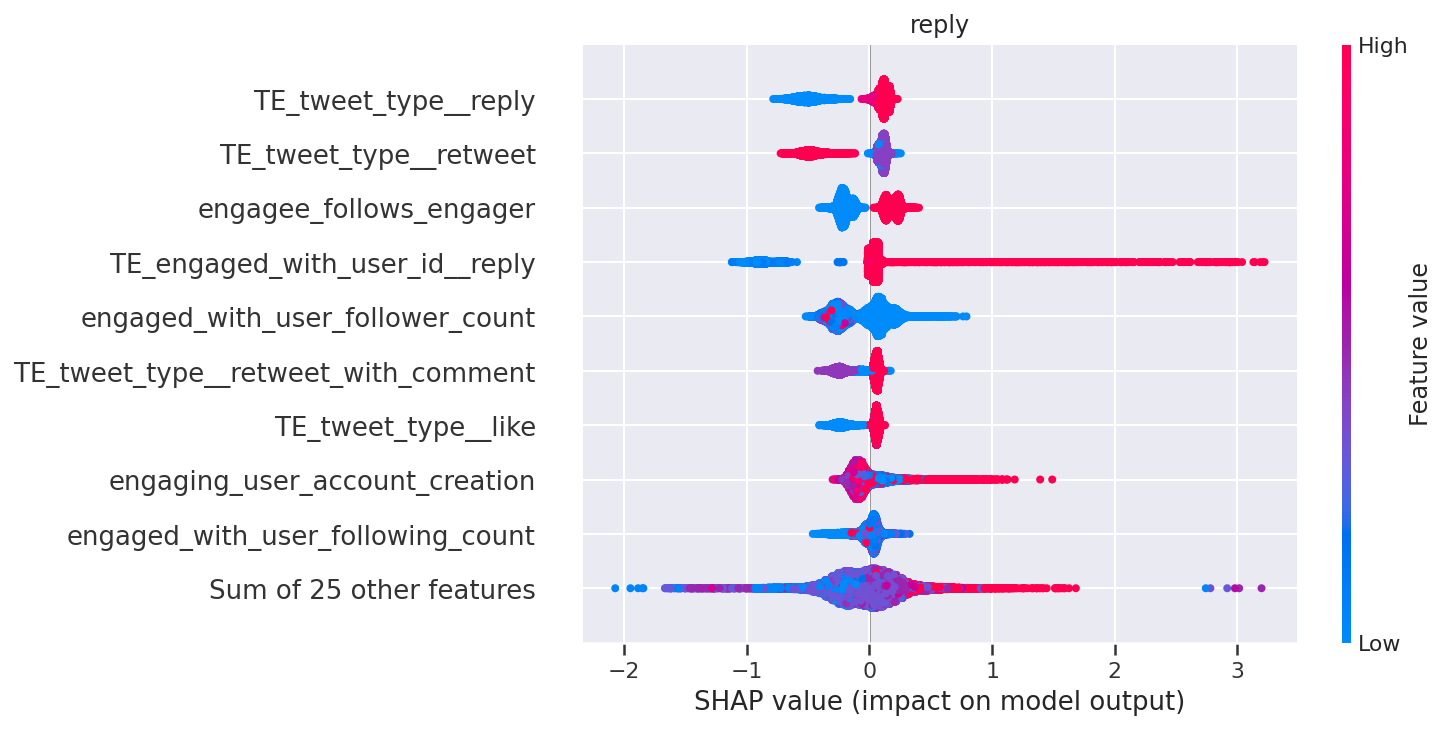

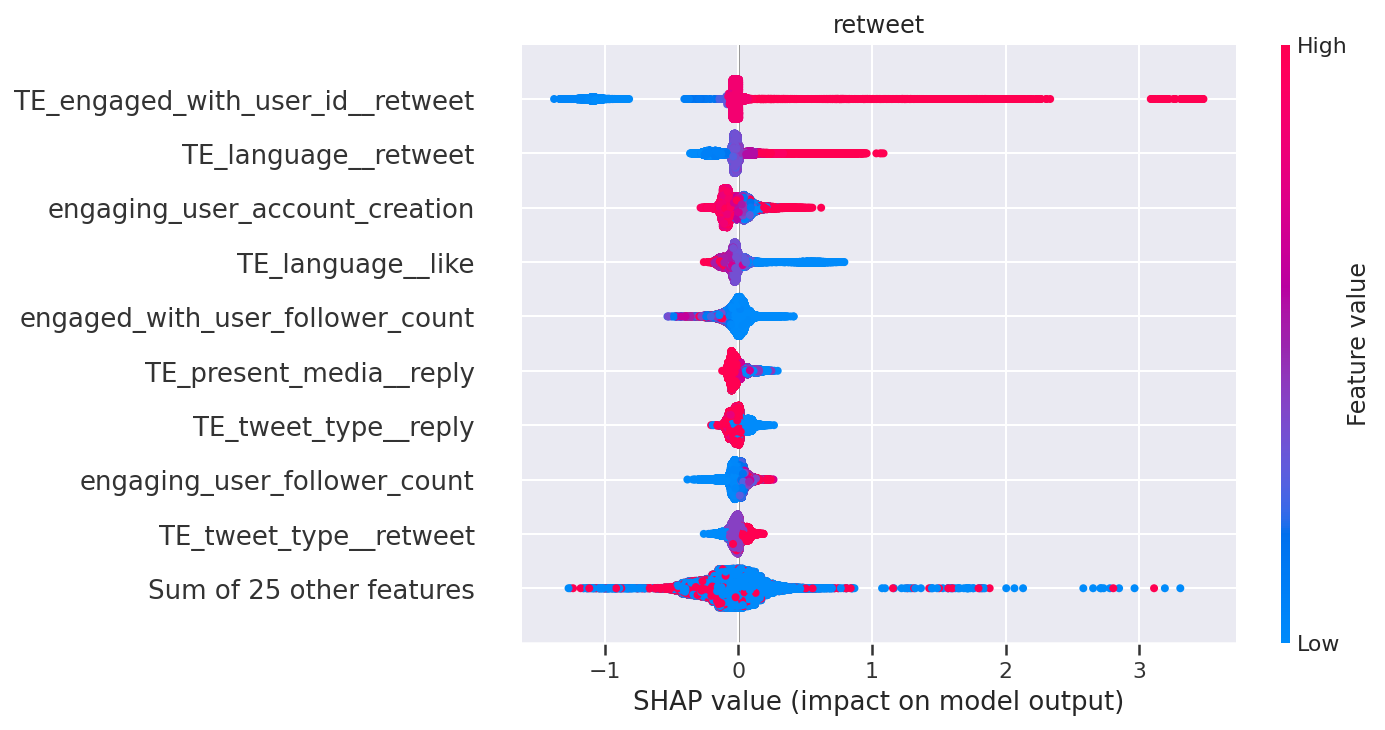

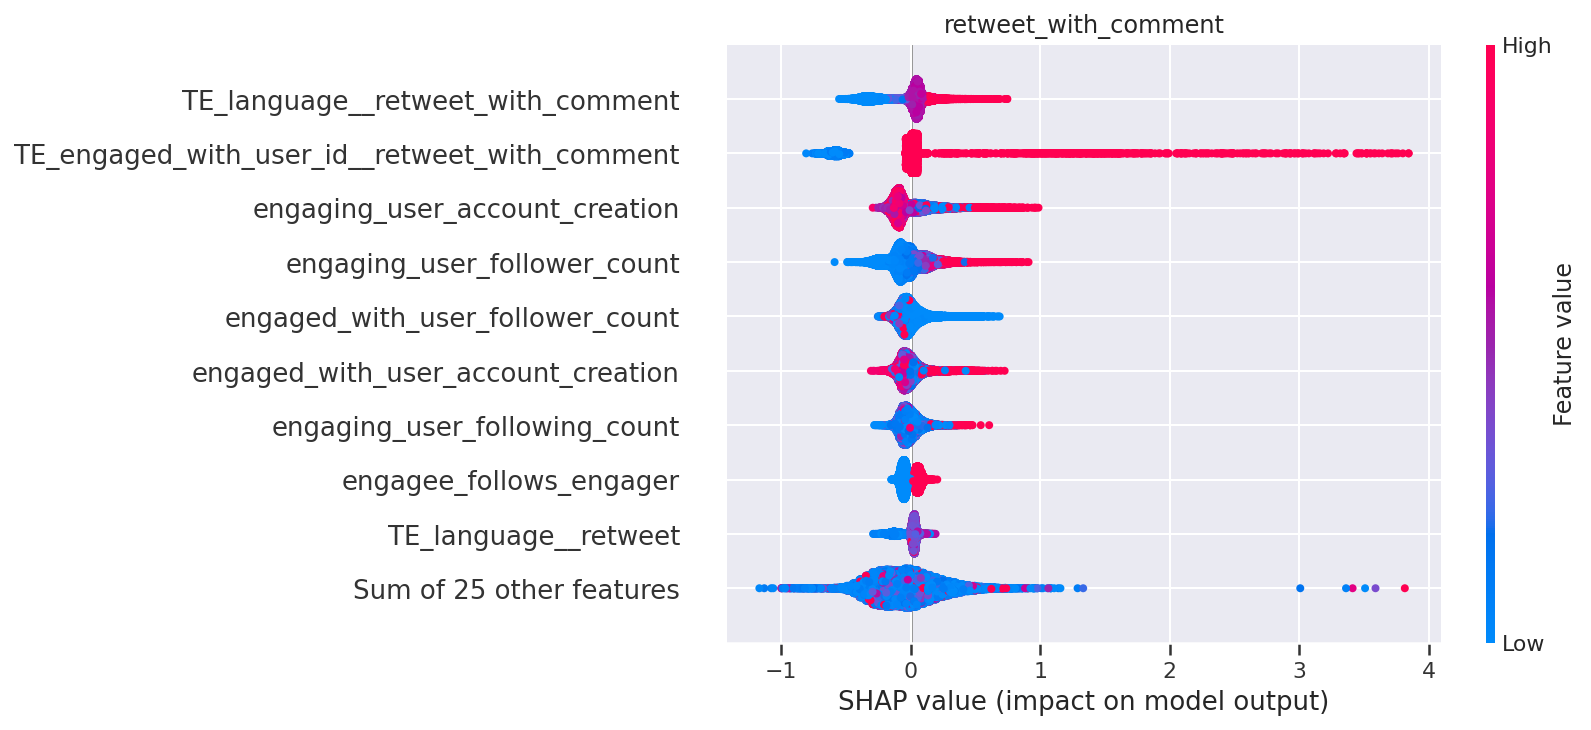

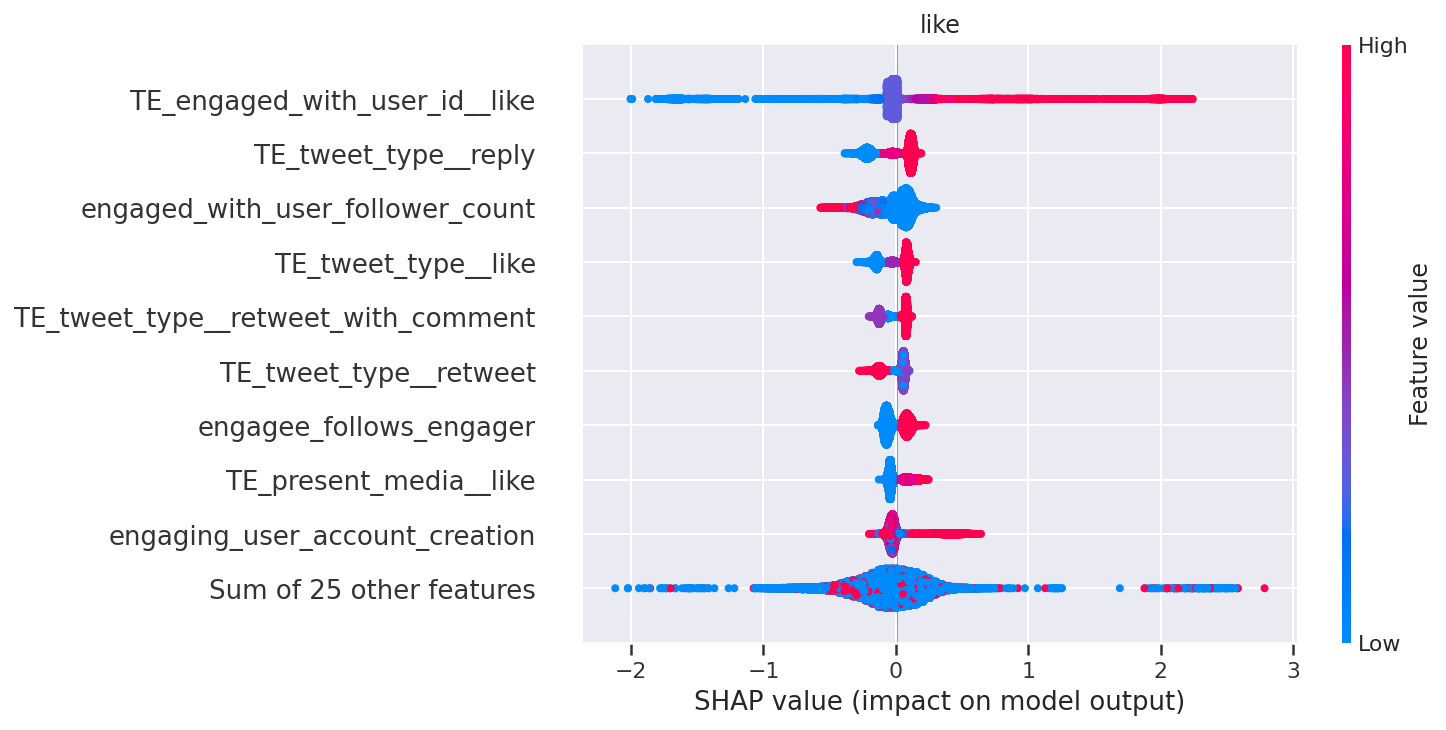

In [142]:
for target, model in models.items():
    plt.title(target)
    shap.plots.beeswarm(shap.Explainer(model)(df_test_features))